In [3]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
import os 
import xarray as xr
import numpy as np
import pandas as pd
import datetime

from tqdm import tqdm
import pystuff as ps
import contextily as ctx
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from dateutil.relativedelta import relativedelta

import weather_config as config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def plot_era_data(data, xlims, ylims, village_data=None, villages = False, cmap="jet", vmin=None, vmax=None):
    fig = plt.figure(figsize=(24, 12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    # generate a basemap with country borders
    ax.add_feature(cfeat.LAKES)
    ax.add_feature(cfeat.RIVERS)
    ax.add_feature(cfeat.BORDERS)
    # add era5 data
    p = data.plot(ax=ax, cmap=cmap, vmin = vmin, vmax = vmax)
    # add villages
    if villages:
        gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(village_data["gps_lon"], village_data["gps_lat"]), crs='epsg:4326')
        gdf.plot(ax=ax, marker="x", markersize=8, color="black", alpha=0.7)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

In [83]:
# Average over area of interest (simple version, rectangle)
#area_of_interest = [-15, 30.5, -10.5, 33.5] # eastern zambia
area_of_interest = [-18, 22, -9, 34] # whole of Zambia

xlims = [area_of_interest[1], area_of_interest[3]]
ylims = [area_of_interest[0], area_of_interest[2]]

## Get datasets

In [14]:
# load datasets
yearly_ds = xr.open_dataset(os.path.join(config.weather_path, "rain_season_dt.nc"))
avg_ds = xr.open_dataset(os.path.join(config.weather_path, "rain_season_avg_dt.nc"))

# load and combine monthly data
monthly_era = xr.open_mfdataset(paths=os.path.join(config.monthly_path, "*.nc"))

# get combined survey data
survey_data = pd.read_csv(config.survey_path) 

# elevation data
eldir = "../../data/elevation/elevation_data.nc"
elev_dt = xr.open_dataset(eldir)

In [70]:
# set up for time series plots
lat = yearly_ds['latitude'].values
lon = yearly_ds['longitude'].values
time = yearly_ds['time'].values
time_m = monthly_era['time'].values

## Elevation
Elevation profile across zambia

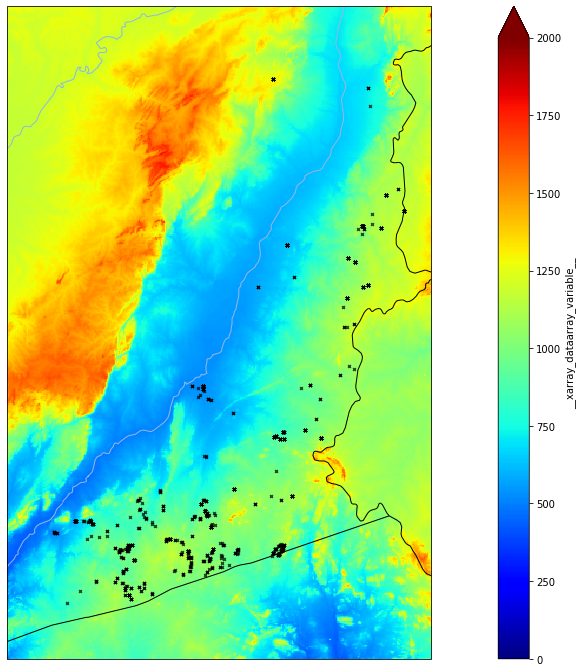

In [43]:
plot_era_data(elev_dt.__xarray_dataarray_variable__, xlims, ylims, village_data = survey_data, villages = True, cmap="jet", vmin=0, vmax=2000)

# Weather data
## Temperature

In [19]:
all_dates = [f"{y}-01-01T00:00:00.000000000" for y in list(range(1982, datetime.datetime.now().year))]

In [32]:
monthly_temp = monthly_era.t2m-273

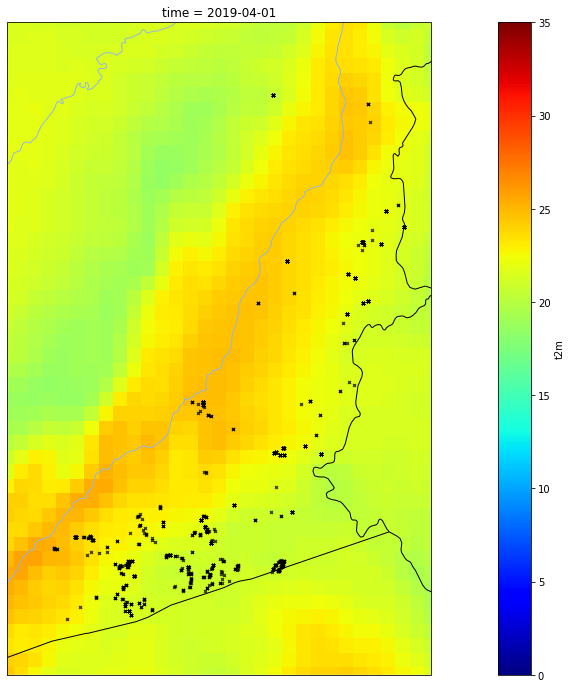

In [81]:
year = "2019"
month = "04"
plot_era_data(monthly_temp.sel(time=f"{year}-{month}-01T00:00:00.000000000"), xlims, ylims, village_data = survey_data, villages = True, cmap="jet", vmin=0, vmax=35)

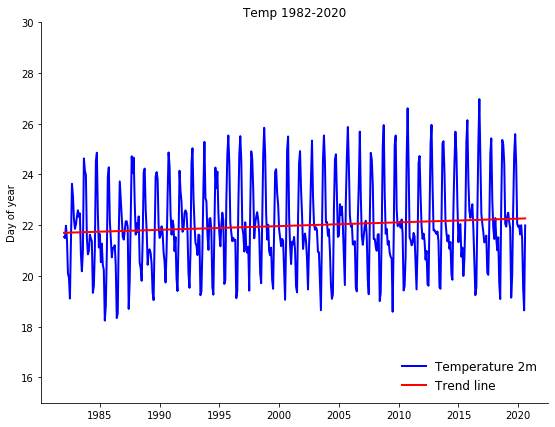

Slope: 0.0012256904936214952


In [80]:
myvar=monthly_temp.fillna(value = 0).values
nasstn, sasst_map = ps.getbox(area_of_interest,lat,lon,myvar,returnmap=True)

# Running Mean
#nasstn_rm = ps.runmean(nasstn,window=5)
#nasstn_rm_fill = ps.runmean(nasstn,window=5,fillaround=True)
# Trend
nasstndt, slope, trend = ps.ddetrend(nasstn, returnTrend=True)
# Plot
fig = plt.figure(figsize=(20,7))
ax=fig.add_subplot(1,2,1)
ps.nospines(ax)
plt.axhline(0,color='grey',ls='--')
plt.plot(time_m,nasstn,'b',lw=2, label='Temperature 2m')
#plt.plot(time_m,nasstn_rm,'b',lw=2, label='5-year running mean')
plt.plot(time_m,trend,'-r', lw=2, label='Trend line')
plt.ylim((15,30))
plt.ylabel('Day of year')
plt.title('Temp 1982-2020')
ps.leg(loc='lower right', fontsize=12)
plt.show()

print(f"Slope: {slope}")

## Flood events

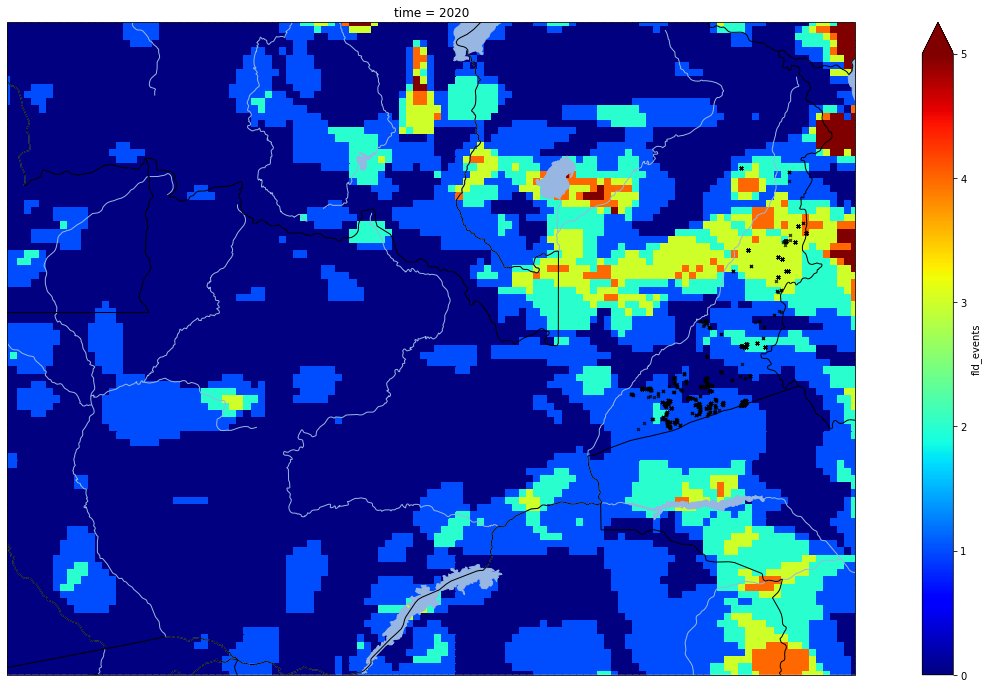

In [84]:
season = 2020
plot_era_data(yearly_ds.fld_events.sel(time=season), xlims, ylims, village_data = survey_data, villages = True, cmap="jet", vmin=0, vmax=5)

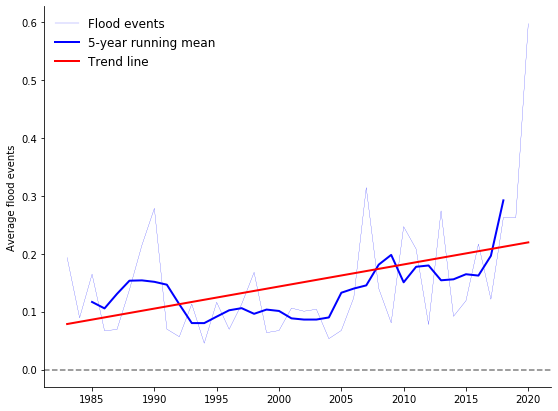

Slope: 0.0038083480417576525


In [79]:
myvar = yearly_ds.fld_events.fillna(value = 0).values
nasstn, sasst_map = ps.getbox(area_of_interest,lat,lon,myvar,returnmap=True)

# Running Mean
nasstn_rm = ps.runmean(nasstn,window=5)
nasstn_rm_fill = ps.runmean(nasstn,window=5,fillaround=True)
# Trend
nasstndt, slope, trend = ps.ddetrend(nasstn, returnTrend=True)
# Plot
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1,2,1)
ps.nospines(ax)
plt.axhline(0,color='grey',ls='--')
plt.plot(time,nasstn,'b',lw=0.2, label='Flood events')
plt.plot(time,nasstn_rm,'b',lw=2, label='5-year running mean')
plt.plot(time,trend,'-r', lw=2, label='Trend line')
#plt.ylim((0,0.5))
plt.ylabel('Average flood events')
ps.leg(loc='upper left', fontsize=12)
plt.show()

print(f"Slope: {slope}")

## Rain season
### Start of season
#### For specific year

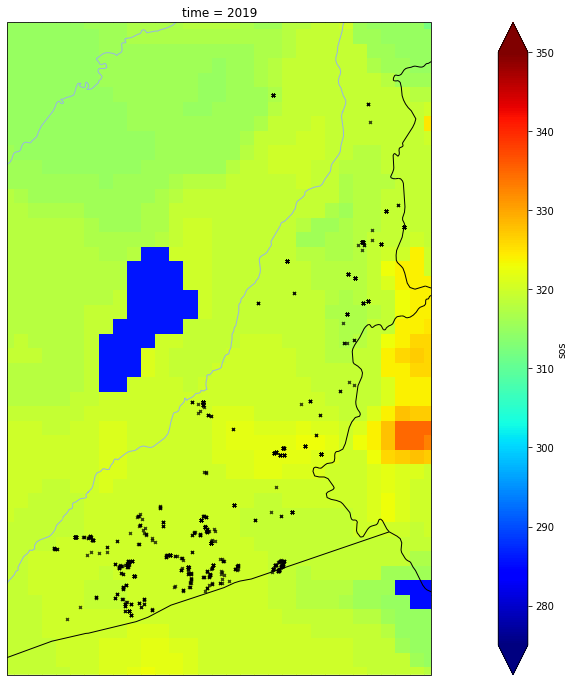

In [49]:
season = 2019
plot_era_data(yearly_ds.sos.sel(time=season), xlims, ylims, village_data = survey_data, villages = True, cmap="jet", vmin=275, vmax=350)

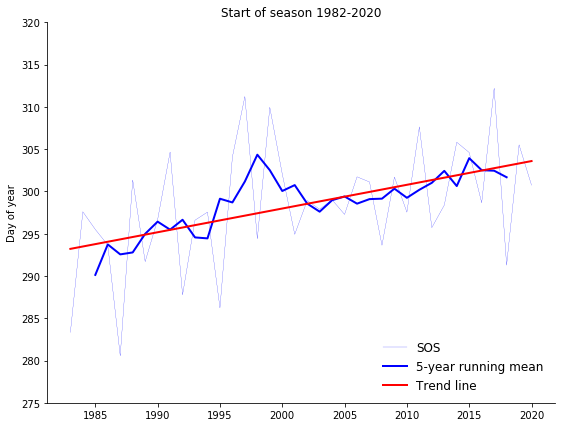

Slope: 0.2806345317329296


In [78]:
myvar=yearly_ds.sos.fillna(value = 0).values
nasstn, sasst_map = ps.getbox(area_of_interest,lat,lon,myvar,returnmap=True)

# Running Mean
nasstn_rm = ps.runmean(nasstn,window=5)
nasstn_rm_fill = ps.runmean(nasstn,window=5,fillaround=True)
# Trend
nasstndt, slope, trend = ps.ddetrend(nasstn, returnTrend=True)
# Plot
fig = plt.figure(figsize=(20,7))
ax=fig.add_subplot(1,2,1)
ps.nospines(ax)
plt.axhline(0,color='grey',ls='--')
plt.plot(time,nasstn,'b',lw=0.2, label='SOS')
plt.plot(time,nasstn_rm,'b',lw=2, label='5-year running mean')
plt.plot(time,trend,'-r', lw=2, label='Trend line')
plt.ylim((275,320))
plt.ylabel('Day of year')
plt.title('Start of season 1982-2020')
ps.leg(loc='lower right', fontsize=12)
plt.show()

print(f"Slope: {slope}")

#### Average since 1982

In [52]:
plot_era_data(avg_ds.sos_avg, xlims, ylims, village_data = survey_data, villages = True, cmap="jet", vmin=275, vmax=350)

### Total season rainfall [mm]
#### For specific year

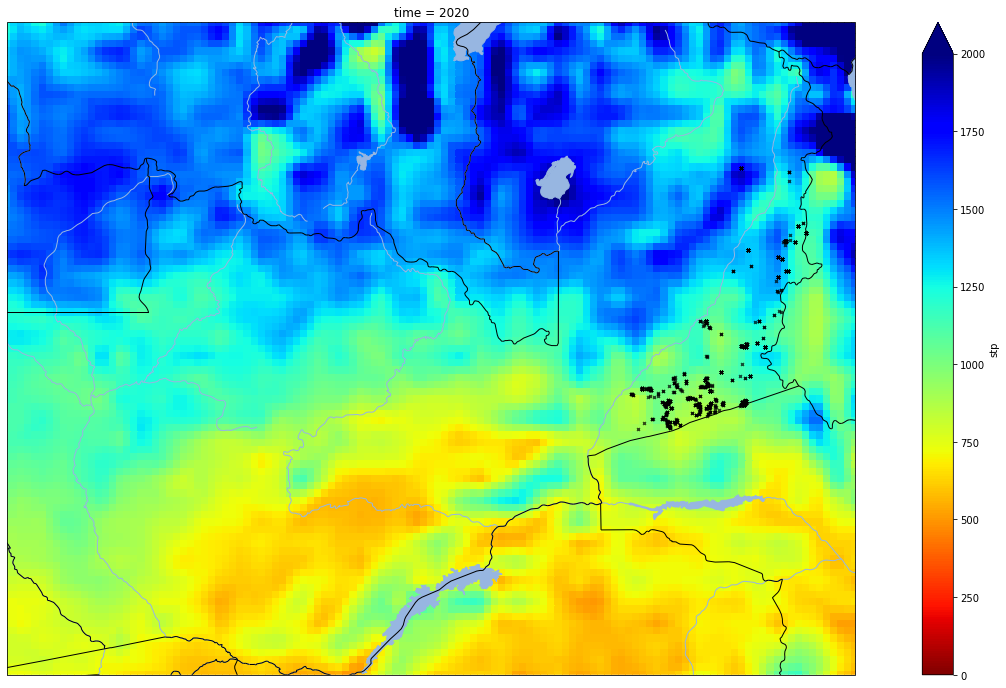

In [85]:
season = 2020
plot_era_data(yearly_ds.stp.sel(time=season)*1000, xlims, ylims, village_data = survey_data, villages = True, cmap="jet_r", vmin=0, vmax=2000)

#### Average since 1982

In [54]:
plot_era_data(avg_ds.stp_avg*1000, xlims, ylims, village_data = survey_data, villages = True, cmap="jet_r", vmin=0, vmax=2000)

In [77]:
myvar=yearly_ds.stp.fillna(value = 0).values*1000
nasstn, sasst_map = ps.getbox(area_of_interest,lat,lon,myvar,returnmap=True)

# Running Mean
nasstn_rm = ps.runmean(nasstn,window=5)
nasstn_rm_fill = ps.runmean(nasstn,window=5,fillaround=True)
# Trend
nasstndt, slope, trend = ps.ddetrend(nasstn, returnTrend=True)
# Plot
fig = plt.figure(figsize=(20,7))
ax=fig.add_subplot(1,2,1)
ps.nospines(ax)
plt.axhline(0,color='grey',ls='--')
plt.plot(time,nasstn,'b',lw=0.2, label='Average total rain season percipitation')
plt.plot(time,nasstn_rm,'b',lw=2, label='5-year running mean')
plt.plot(time,trend,'-r', lw=2, label='Trend line')
plt.ylim((900,1500))
plt.ylabel('Total rain season percipitation [mm]')
plt.title('Total rain season percipitation 1982-2020')
ps.leg(loc='lower left', fontsize=11)
plt.show()

print(f"Slope: {slope}")

Slope: -0.5407199588794114


# Additional maps

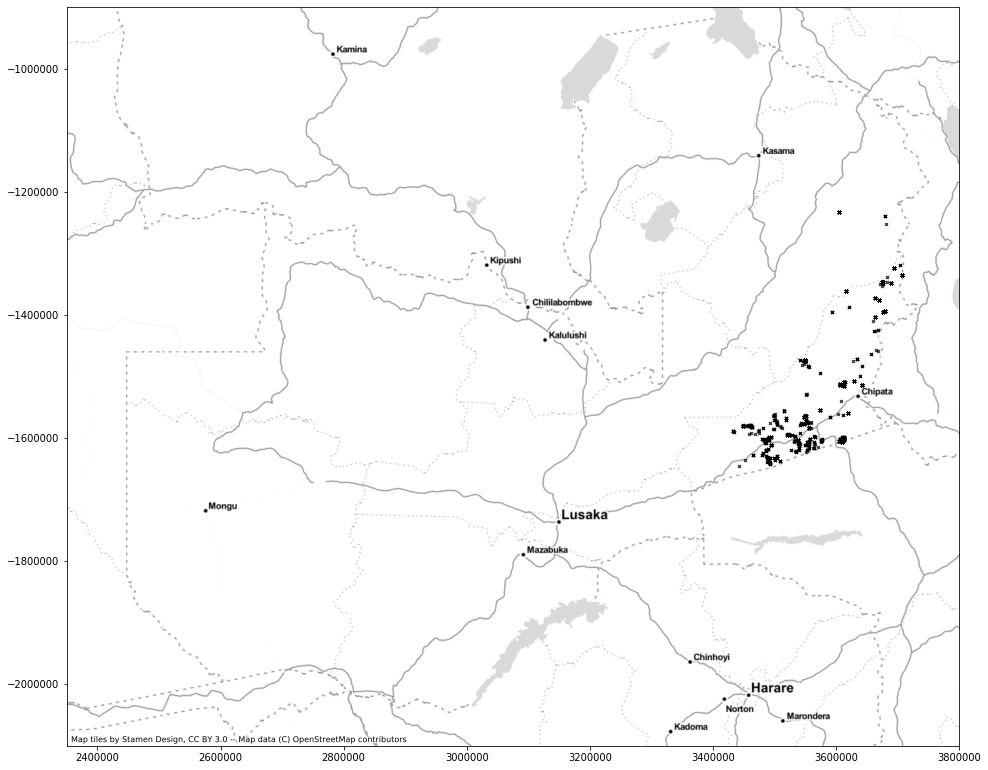

In [176]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(survey_data["gps_lon"], survey_data["gps_lat"]), crs='epsg:4326')
gdf = gdf.to_crs(epsg=3857)

extent = (2350000, 3800000, -2100000, -900000)

fig, ax = plt.subplots(figsize=(16, 16))
gdf.plot(ax=ax, marker="x", markersize=8, color="black", alpha=0.7)
ax.axis(extent)
ctx.add_basemap(ax, source = ctx.providers.Stamen.TonerLite)